## Travel Google Search Trend Prediction

### Business Questions
- **Business Question 1: What are the external factors that impact the volume of Google Search about domestic travel to Las Vegas in United State?**
    - Granger Causarity Test
        - H0: The input variable X does not cause the changes in the future demand of output variable Y.
        - H1: The input variable X does cause the change in  the future demand of output variable Y.
    - Cointegration Test
- **Business Question 2: What is the time lag between the external factors impact the volume of Google Search?**
    - Pick the Order (P) of VAR model that gives a model with the least AIC by iteratively fit increasing orders of VAR model 
- **Business Question 3: How to determ the variables to incporate into the demand forecasting model?**
    - Select the best performing model based on Root Mean Squared Error (RMSE), Mean Absolute Percentage Error (MAPE), Mean Absolute Error (MAE), and Mean Squared Error (MSE)


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from datetime import datetime

# Import Statsmodels
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic

#supress scientific notation
pd.set_option('display.float_format', '{:.3f}'.format)

### To-Dos
1. Import the dataset
2. Analyze the time series characteristics
3. Test for causation among the time series
4. Test for cointegration among the time series
5. Split the dataset into Training and Test
4. Test for stationarity
5. Transform the series to make it stationary, if needed
6. Find optimal order (p)
7. Prepare training and test datasets
8. Train the model
9. Roll back the transformations, if any.
10. Evaluate the model using test set
11. Forecast to future

#### 1. Import the dataset

In [2]:
df = pd.read_csv('travel_data.csv', parse_dates=True)
df = df.sort_values('DATE').reset_index(drop=True)
df = df[df['DATE']>='2018']
df['Visitor Volume'] = df['Visitor Volume'].astype('int')
df['DATE'] = pd.to_datetime(df['DATE']).dt.strftime('%Y-%m')
df.set_index('DATE', inplace = True)
df.index = pd.DatetimeIndex(df.index, freq=None)

df.tail()

,Google Trend Index,Visitor Volume,Average Daily Room Rate (ADR),CPI,Unemployment Rate,Cost per Gallon
DATE,,,,,,
2023-01-01,78,3275300,191.620,299.170,3.400,3.330
2023-02-01,78,3081800,176.640,300.840,3.600,3.250
2023-03-01,80,3655800,213.250,301.836,3.500,2.930
2023-04-01,75,3385500,171.050,303.363,3.400,2.660
2023-05-01,79,3498000,183.400,304.127,3.700,3.450


In [3]:
# Normalize the visitor volume, Average Daily Room Rate, and CPI data with Z-score
avg, dev  = df['Visitor Volume'].mean(), df['Visitor Volume'].std()
df['Visitor Volume'] = (df['Visitor Volume']-avg)/dev

avg, dev  = df['Average Daily Room Rate (ADR)'].mean(), df['Average Daily Room Rate (ADR)'].std()
df['Average Daily Room Rate (ADR)'] = (df['Average Daily Room Rate (ADR)']-avg)/dev

avg, dev  = df['CPI'].mean(), df['CPI'].std()
df['CPI'] = (df['CPI']-avg)/dev

df



,Google Trend Index,Visitor Volume,Average Daily Room Rate (ADR),CPI,Unemployment Rate,Cost per Gallon
DATE,,,,,,
2018-01-01,87,0.496,0.421,-1.167,4.000,2.020
2018-02-01,87,0.203,-0.566,-1.104,4.100,2.020
2018-03-01,89,0.892,-0.120,-1.072,4.000,1.960
2018-04-01,82,0.668,-0.279,-1.016,4.000,2.080
2018-05-01,88,0.759,-0.120,-0.957,3.800,2.180
...,...,...,...,...,...,...
2023-01-01,78,0.364,1.714,1.719,3.400,3.330
2023-02-01,78,0.149,1.237,1.813,3.600,3.250
2023-03-01,80,0.787,2.402,1.869,3.500,2.930


In [4]:
#The list of variables
input_variables = df.columns.values[1:].tolist()
input_variables

['Visitor Volume',
 'Average Daily Room Rate (ADR)',
 'CPI',
 'Unemployment Rate',
 'Cost per Gallon']

#### 2. Analyze the characteristics of the time series

''

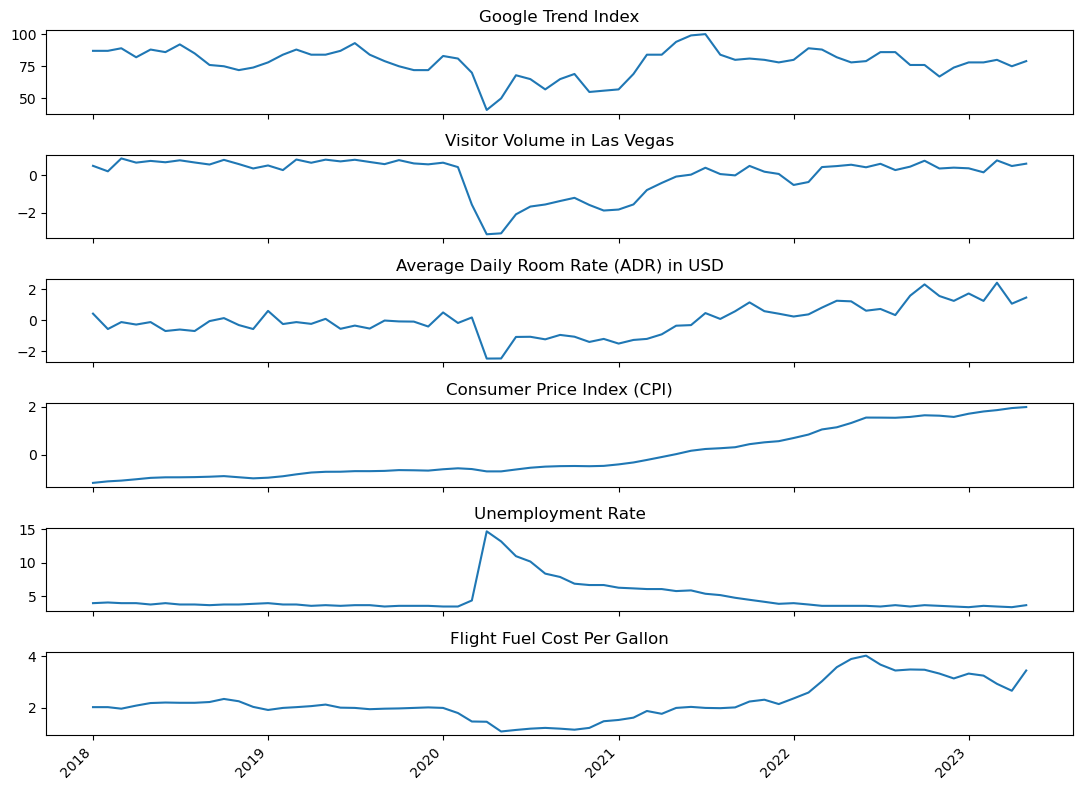

In [5]:
#Visualize the overall trend of each time series

fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(6,1, figsize = (11,8), sharex=True)
ax1.plot(df.index,df['Google Trend Index'])
ax1.set_title('Google Trend Index')

ax2.plot(df.index,df['Visitor Volume'])
ax2.set_title('Visitor Volume in Las Vegas')

ax3.plot(df.index,df['Average Daily Room Rate (ADR)'])
ax3.set_title('Average Daily Room Rate (ADR) in USD')

ax4.plot(df.index, df['CPI'])
ax4.set_title('Consumer Price Index (CPI)')

ax5.plot(df.index, df['Unemployment Rate'])
ax5.set_title('Unemployment Rate')

ax6.plot(df.index, df['Cost per Gallon'])
ax6.set_title('Flight Fuel Cost Per Gallon')

fig.autofmt_xdate(rotation=45)
plt.tight_layout()
;

In [6]:
# A function to create Decomposition and plot trend, seasonality, and errors
def decomposition(df):
    from statsmodels.tsa.seasonal import seasonal_decompose
    variables = df.columns.values
    for i in variables:
        result = seasonal_decompose(df[i])

        fig = plt.figure(figsize = (12,8))
        fix = result.plot();

<Figure size 1200x800 with 0 Axes>

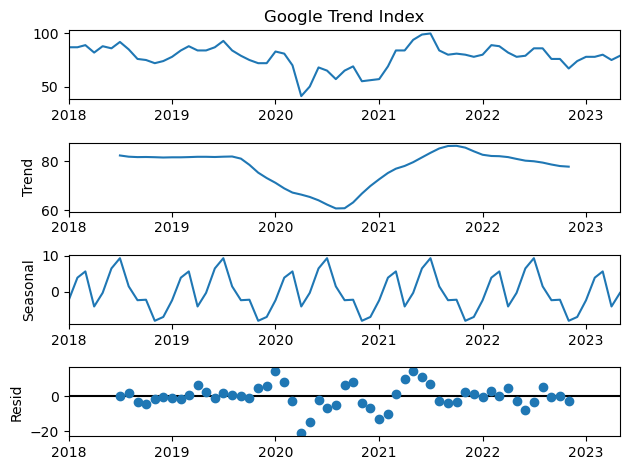

<Figure size 1200x800 with 0 Axes>

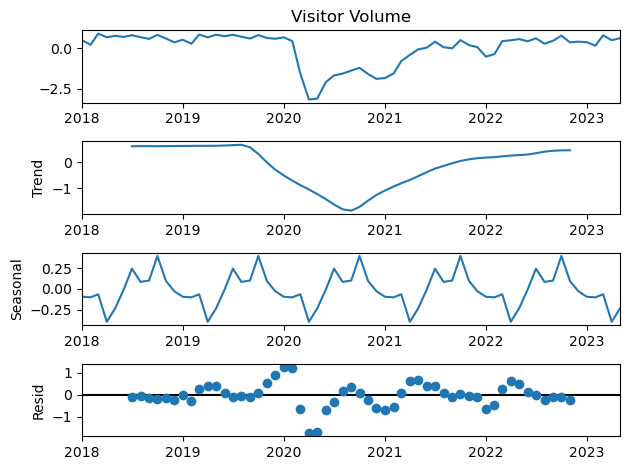

<Figure size 1200x800 with 0 Axes>

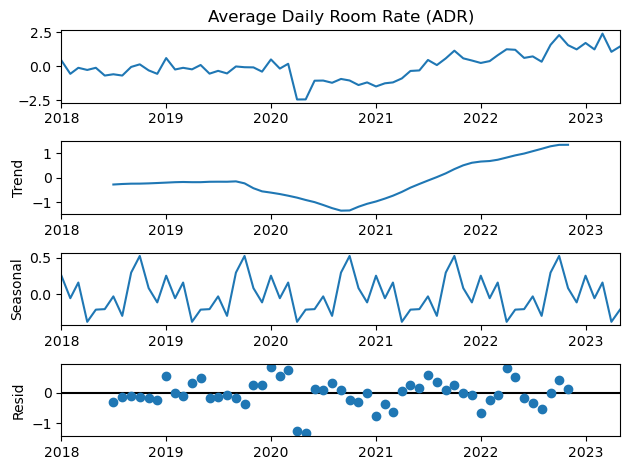

<Figure size 1200x800 with 0 Axes>

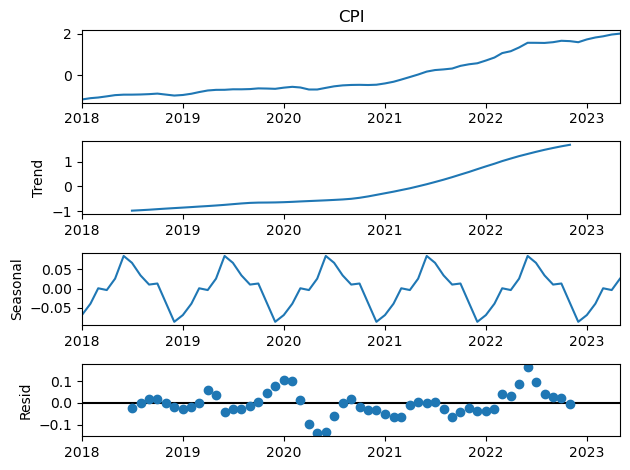

<Figure size 1200x800 with 0 Axes>

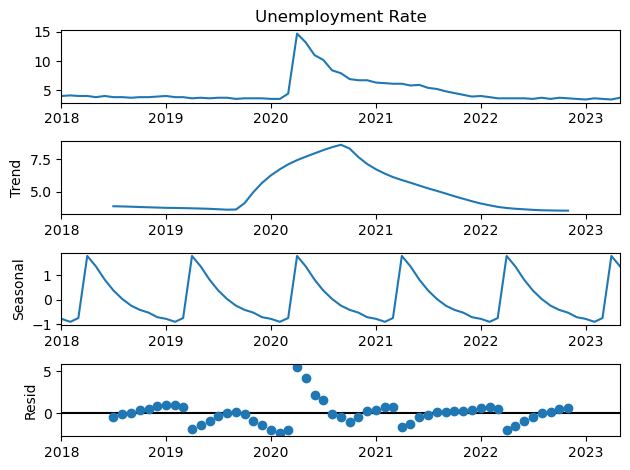

<Figure size 1200x800 with 0 Axes>

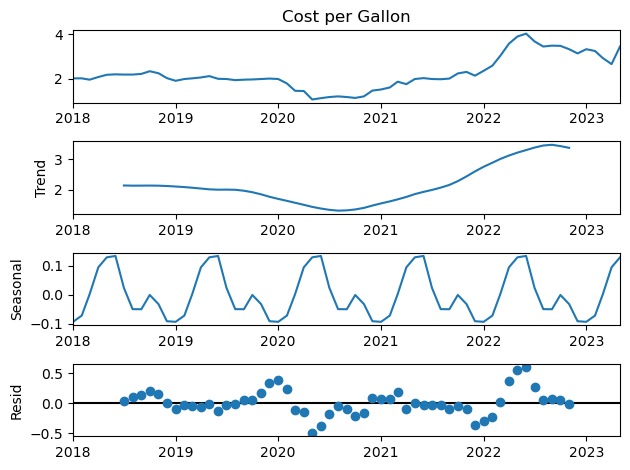

In [7]:
decomposition(df)

##### Observations
- Google Trend Index, Visitor voluhme, Verage daily room rate has failry similar trend.
- Flight Fuel has somewhat similar trend as Google Trend Index but slighly lagged from the Google Trend index.
- Exmplotment rate is an inverse relationship to Google Trend Index
- Consumer Price index does not seem to have similar trend as Google Trend Index.

#### 3. Test for Causation using Granger's Causality Test

**Granger's Causality Test**
Null Hypothesis: The past value of input variable X do not cause the output variable Y.


*H0*: The past value of the input variable X does not cause the output variable Y. <br>
*H1*: The past value of the input variable X causes the output variable Y.

Row (Y): Output variables <br>
Columns (X): Inputvariables

*If s given p-value is < 0.05, the corresponding X series (column) causes the Y (row).*

In [8]:
#A funcion to check Granger's causality of all possible combination of the time series
def check_causality(data, variables, test='ssr_chi2test', verbose=False, maxlag = 12):
    from statsmodels.tsa.stattools import grangercausalitytests
    #create a empty DataFram:
        #Columns: variables
        #Rows: Variables
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns = variables, index=variables)
    for col in df.columns:
        for row in df.index:
            test_result = grangercausalitytests(data[[row, col]], maxlag=maxlag, verbose=verbose)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {row}, X = {col}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[row, col] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    
    sns.heatmap(df, cmap='coolwarm', annot= True)
    
    return df


,Google Trend Index_x,Visitor Volume_x,Average Daily Room Rate (ADR)_x,CPI_x,Unemployment Rate_x,Cost per Gallon_x
Google Trend Index_y,1.000,0.000,0.000,0.001,0.000,0.242
Visitor Volume_y,0.121,1.000,0.023,0.122,0.212,0.127
Average Daily Room Rate (ADR)_y,0.004,0.000,1.000,0.000,0.000,0.000
CPI_y,0.085,0.000,0.001,1.000,0.005,0.001
Unemployment Rate_y,0.050,0.000,0.183,0.415,1.000,0.025
Cost per Gallon_y,0.351,0.125,0.123,0.001,0.053,1.000


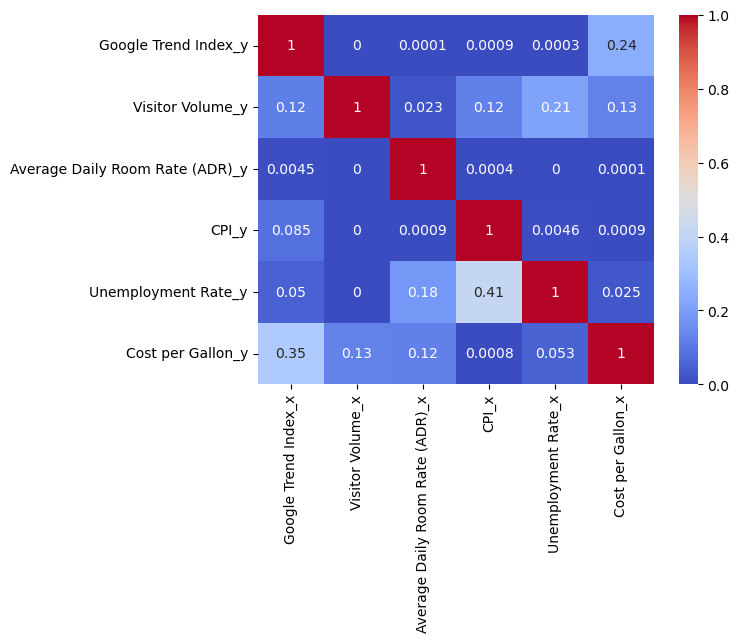

In [9]:
causality = check_causality(df, df.columns.values)
causality

In [10]:
causality.to_csv('causality_test.csv')

##### Obseravatisons
- Google Trend Index is Granger caused by all variables (visitor volume, average darily room rate, CPI, employment rate) except for cost per gallon as p-value of Grander causality test are less than the significance level at 0.05.

### 4. Cointegration Test

Cointegration test helps to establish the presence of a statistically significant connection between two or more time series. <br> Vector Autoregression (VAR) model assume the cointegration of time series used for the model.

In [11]:
# A function to test cointegration and show the summary
def cointegration_test(df, alpha=0.05):
    from statsmodels.tsa.vector_ar.vecm import coint_johansen
    out = coint_johansen(df, -1, 6)
    d = {'0.90':0, '0.95':1, '0.99':2}
    
    traces = out.lr1  #trace statistic
    cvts = out.cvt[:, d[str(1-alpha)]]  #Critical values (90%, 95%, 99%) of trace statistic
    
    def adjust(val, length= 6): return str(val).ljust(length)

    variables = df.columns.values
    attributes = ["Test Stat" ," > C(95%)", "Signif"]

    summary = pd.DataFrame(np.zeros((len(variables), len(attributes))), columns = attributes, index=variables)
    for var, trace, cvt in zip(variables, traces, cvts):
        sig = trace > cvt
        summary.loc[var, attributes] = [round(trace,2), cvt,  sig]
        summary['Signif'] = summary['Signif'].astype('bool')
    return summary
    

In [12]:
cointegration_test_result = cointegration_test(df)
cointegration_test_result

,Test Stat,> C(95%),Signif
Google Trend Index,225.010,83.938,True
Visitor Volume,145.510,60.063,True
Average Daily Room Rate (ADR),80.280,40.175,True
CPI,39.470,24.276,True
Unemployment Rate,17.500,12.321,True
Cost per Gallon,3.150,4.130,False


#### Observations
- Fuel cost is the only variable does not has statistically significant cointegration with other variables.
- Therefore, fuel cost will be removed from the predictive model.

In [13]:
#Removing fuel cost from the dataframe
df = df.drop(columns = 'Cost per Gallon')
df.head()

,Google Trend Index,Visitor Volume,Average Daily Room Rate (ADR),CPI,Unemployment Rate
DATE,,,,,
2018-01-01,87,0.496,0.421,-1.167,4.000
2018-02-01,87,0.203,-0.566,-1.104,4.100
2018-03-01,89,0.892,-0.120,-1.072,4.000
2018-04-01,82,0.668,-0.279,-1.016,4.000
2018-05-01,88,0.759,-0.120,-0.957,3.800


### 5. Split the series into Training and Test Dataset

- Forecaset the next 3 observations

In [14]:
nobs = 4
df_train, df_test = df[0:-nobs], df[-nobs:]

print(df_train.shape)
print(df_test.shape)

(61, 5)
(4, 5)


### 6. Check Stationality and Transform if the Series is not Stationary
- Detect non-stationary using the Dickey-Fuller test <br>

##### Augmented Dickey Fuller Test 
Null hypothesis: non-stationary <br>
Alternative hypothesis: Stationary

In [15]:
# Function to perform a ADF test
def ADF_test(measure):
    adf, pval, usedlag, nobs,crit_vals, icbest = adfuller(measure)
    print(f'ADF test statistic: {adf}')
    print(f'ADF p-values: {pval}')
    print(f'ADF number of lags used: {usedlag}')
    print(f'ADF number of observations: {nobs}')
    print(f'ADF critical values: {crit_vals}')
    print(f'ADF best information criterion: {icbest}')

    if pval < 0.05:
        print('\nReject the null hypothesis (non-stationaity). - The data is stational ')
    else:
        print('\nFail to reject the null pyhothsis. - The data is non stational.')
        
    #return adf, pval, usedlag, nobs,crit_vals, icbest

In [16]:
# A function to perform a ADF test for all variables
def ADF_test(df):
    
    variables = df.columns.values
    attributes = ["ADF test statistic", "p-value", "number of lags used", "number of observations","critical values", "best information criterion", 'Significance']

    summary = pd.DataFrame(np.zeros((len(variables), len(attributes))), columns = attributes, index=variables)
    
    for var in variables:
        adf, pval, usedlag, nobs,crit_vals, icbest = adfuller(df[var])
        sig = pval < 0.05         
        summary.loc[var, attributes] = [adf, pval, usedlag, nobs,crit_vals, icbest, sig]
    
    #summary.apply(lambda x: round(x, 3))
    summary['Significance'] = summary['Significance'].astype('bool')
    return summary

In [17]:
ADF = ADF_test(df_train)
ADF

,ADF test statistic,p-value,number of lags used,number of observations,critical values,best information criterion,Significance
Google Trend Index,-2.568,0.100,2.000,58.000,"{'1%': -3.548493559596539, '5%': -2.9128365947...",340.398,False
Visitor Volume,-2.427,0.134,1.000,59.000,"{'1%': -3.5463945337644063, '5%': -2.911939409...",62.896,False
Average Daily Room Rate (ADR),-2.273,0.181,0.000,60.000,"{'1%': -3.5443688564814813, '5%': -2.911073148...",94.321,False
CPI,0.440,0.983,7.000,53.000,"{'1%': -3.560242358792829, '5%': -2.9178502070...",-147.343,False
Unemployment Rate,-2.400,0.142,0.000,60.000,"{'1%': -3.5443688564814813, '5%': -2.911073148...",182.319,False


##### Observations
- All p-vale are greated than 0.05, hence failed to reject the null hpyothesis that series is non-stationary.
- As a result, all time series need to remove trend.

##### Deferencing
- Remove the trend to have only seasonal variation
- If the data is non-stationary, perform a differencing technique to stationary the data

In [18]:
#A function to deference given series. Created a new data frame with differenced values
def defference(df):
    df_differenced = df.copy()
    
    for i in df.columns.values:
        df_differenced[i] = df[i].diff()
        fig, ax = plt.subplots(figsize = (10,4))
        plt.plot(df_differenced[i])
        plt.plot(df[i])
        plt.title(f' Differencing {i}')
        plt.legend(['differenced', 'original'])
        plt.show()
    return df_differenced

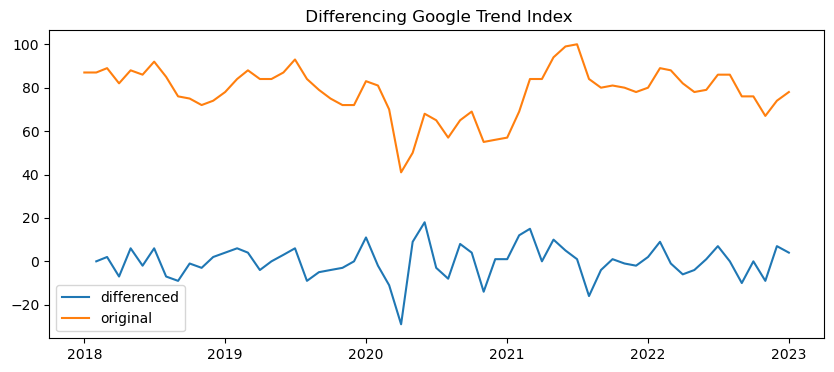

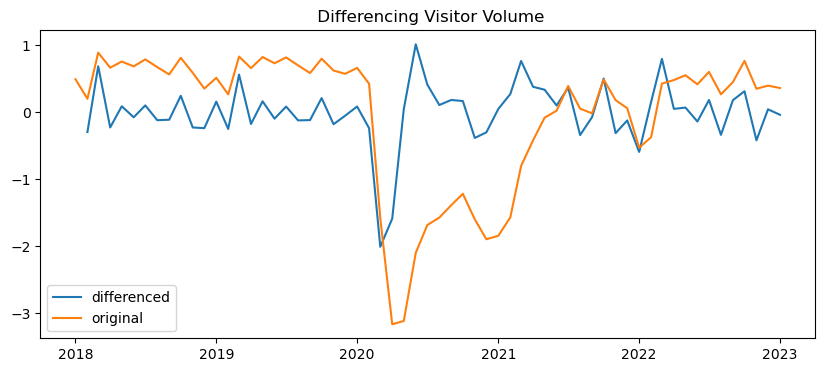

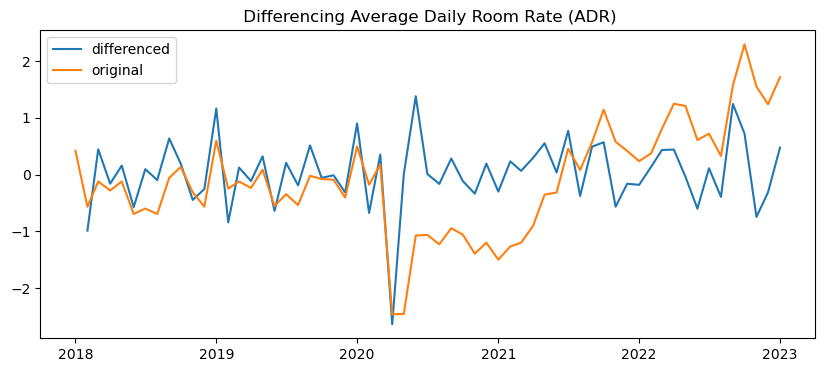

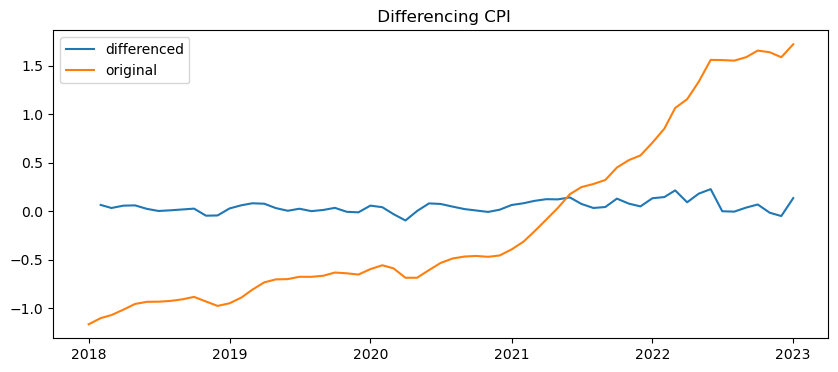

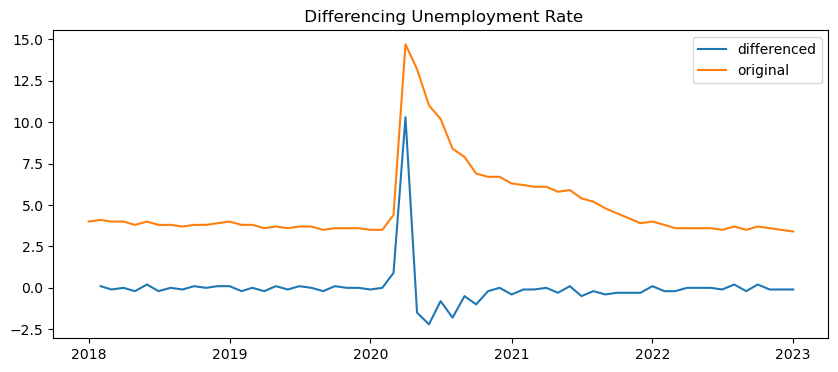

,Google Trend Index,Visitor Volume,Average Daily Room Rate (ADR),CPI,Unemployment Rate
DATE,,,,,
2018-01-01,NaN,NaN,NaN,NaN,NaN
2018-02-01,0.000,-0.293,-0.987,0.063,0.100
2018-03-01,2.000,0.689,0.446,0.032,-0.100
2018-04-01,-7.000,-0.224,-0.159,0.056,0.000
2018-05-01,6.000,0.092,0.159,0.059,-0.200


In [19]:
df_differenced  = defference(df_train)
df_differenced.head()

In [20]:
#Check stationary again
ADF_test(df_differenced.dropna())

,ADF test statistic,p-value,number of lags used,number of observations,critical values,best information criterion,Significance
Google Trend Index,-6.838,0.000,1.000,58.000,"{'1%': -3.548493559596539, '5%': -2.9128365947...",337.375,True
Visitor Volume,-5.457,0.000,1.000,58.000,"{'1%': -3.548493559596539, '5%': -2.9128365947...",64.918,True
Average Daily Room Rate (ADR),-9.708,0.000,0.000,59.000,"{'1%': -3.5463945337644063, '5%': -2.911939409...",91.629,True
CPI,-1.505,0.531,6.000,53.000,"{'1%': -3.560242358792829, '5%': -2.9178502070...",-144.966,False
Unemployment Rate,-7.421,0.000,0.000,59.000,"{'1%': -3.5463945337644063, '5%': -2.911939409...",184.413,True


#### Observation
- All time series except for CPI are stationary. 
- We will perform second differencing on CPI.

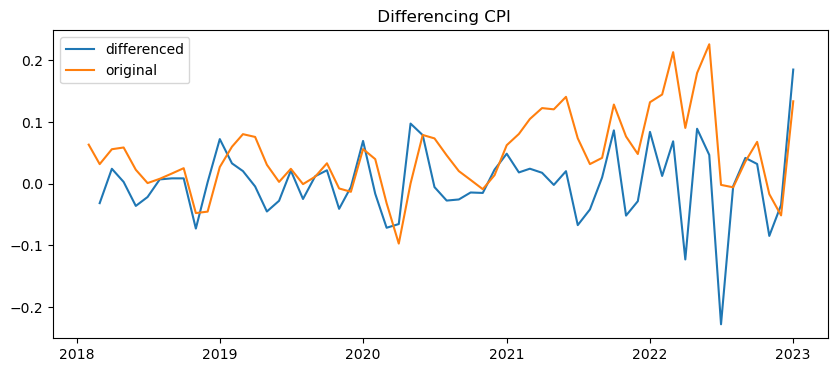

,ADF test statistic,p-value,number of lags used,number of observations,critical values,best information criterion,Significance
CPI,-5.602,0.000,5.000,53.000,"{'1%': -3.560242358792829, '5%': -2.9178502070...",-140.430,True


In [21]:
CPI = df_differenced.dropna().loc[:,'CPI'].to_frame()
CPI_second = defference(CPI).dropna()
ADF_test(CPI_second)

In [22]:
#put the new CPI back 
#CPI_second

all_differenced = df_differenced.copy()
all_differenced = all_differenced.iloc[2:,:]
all_differenced['CPI'] = CPI_second
all_differenced

,Google Trend Index,Visitor Volume,Average Daily Room Rate (ADR),CPI,Unemployment Rate
DATE,,,,,
2018-03-01,2.000,0.689,0.446,-0.032,-0.100
2018-04-01,-7.000,-0.224,-0.159,0.024,0.000
2018-05-01,6.000,0.092,0.159,0.003,-0.200
2018-06-01,-2.000,-0.072,-0.573,-0.036,0.200
2018-07-01,6.000,0.105,0.095,-0.022,-0.200
2018-08-01,-7.000,-0.116,-0.095,0.007,0.000
2018-09-01,-9.000,-0.109,0.637,0.009,-0.100
2018-10-01,-1.000,0.248,0.191,0.009,0.100
2018-11-01,-3.000,-0.225,-0.446,-0.073,0.000


### 8. Find optimal order (p)

In [23]:
model = VAR(all_differenced)

x = model.select_order(maxlags = 8)
x.summary()

/Users/wakanamorlan/anaconda3/envs/py310/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


,AIC,BIC,FPE,HQIC
0,-4.437,-4.247*,0.01183,-4.365
1,-5.076,-3.940,0.006277,-4.642*
2,-5.232,-3.149,0.005530*,-4.436
3,-5.197,-2.167,0.006172,-4.039
4,-5.225,-1.248,0.006974,-3.705
5,-5.467,-0.5428,0.007152,-3.585
6,-5.549,0.3218,0.01033,-3.306
7,-5.838,0.9802,0.01645,-3.233
8,-7.250*,0.5156,0.01510,-4.282


In [24]:
x.selected_orders

{'aic': 8, 'bic': 0, 'hqic': 1, 'fpe': 2}

### 9. Train the model of Selected Order (p)

In [25]:
model_fitted = model.fit(8)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sat, 22, Jul, 2023
Time:                     12:04:57
--------------------------------------------------------------------
No. of Equations:         5.00000    BIC:                   0.515608
Nobs:                     51.0000    HQIC:                  -4.28227
Log likelihood:           28.0348    FPE:                  0.0151044
AIC:                     -7.24957    Det(Omega_mle):     0.000790704
--------------------------------------------------------------------
Results for equation Google Trend Index
                                      coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------------------------------
const                                    0.410035         1.406452            0.292           0.771
L1.Google Trend Index                    0.005870         0.399815     

https://www.youtube.com/watch?v=TpQtD7ONfxQ

### 10. Check for serial Correlation of Residuals using Durbin Watson Statistic

In [26]:
from statsmodels.stats.stattools import durbin_watson
out = durbin_watson(model_fitted.resid)  #Residuals of response variable resulting from estimated coefficients
out

array([1.7555842 , 1.53950947, 1.71539114, 1.72416996, 1.91597751])

In [27]:
for col, val in zip(all_differenced.columns, out):
    print(col, ":", round(val,2))

Google Trend Index : 1.76
Visitor Volume : 1.54
Average Daily Room Rate (ADR) : 1.72
CPI : 1.72
Unemployment Rate : 1.92


### 11. Forecast

In [28]:
#get the lag order
lag_order = model_fitted.k_ar
print(f'lag order: {lag_order}')


#input data for forecasting
forecast_input = all_differenced.values[-lag_order:]
forecast_input

lag order: 8


array([[ 1.00000000e+00, -1.35871562e-01, -5.99709162e-01,
         4.65717349e-02,  0.00000000e+00],
       [ 7.00000000e+00,  1.85613239e-01,  1.11729255e-01,
        -2.27796529e-01, -1.00000000e-01],
       [ 0.00000000e+00, -3.34949551e-01, -3.92803135e-01,
        -3.93722397e-03,  2.00000000e-01],
       [-1.00000000e+01,  1.83165103e-01,  1.24430102e+00,
         4.17345740e-02, -2.00000000e-01],
       [ 0.00000000e+00,  3.16032134e-01,  7.22897827e-01,
         3.18915141e-02,  2.00000000e-01],
       [-9.00000000e+00, -4.15849326e-01, -7.45180015e-01,
        -8.46503153e-02, -1.00000000e-01],
       [ 7.00000000e+00,  4.64033099e-02, -3.10995675e-01,
        -3.44788327e-02, -1.00000000e-01],
       [ 4.00000000e+00, -3.54979757e-02,  4.74610595e-01,
         1.84880788e-01, -1.00000000e-01]])

In [29]:
#Forecast
fc = model_fitted.forecast(y=forecast_input, steps=nobs)
df_forecast = pd.DataFrame(fc, index=df.index[-nobs:], columns = df.columns + '_fc')
df_forecast

,Google Trend Index_fc,Visitor Volume_fc,Average Daily Room Rate (ADR)_fc,CPI_fc,Unemployment Rate_fc
DATE,,,,,
2023-02-01,34.025,1.182,-0.985,0.101,-6.529
2023-03-01,0.229,1.767,4.086,-0.074,1.145
2023-04-01,9.459,0.040,-4.932,0.075,-4.110
2023-05-01,-15.978,1.077,7.487,-0.070,-0.255


### 12. Revert the differenced values

In [30]:
def de_defference(col_name, df_train, df_forecast, second_diff=False):
    """
    A function to revert back to difference values to the original scale.
    """
    df_fc = df_forecast.copy()
    if second_diff == True:
        df_fc[col_name+'_fc']=(df_train[loc_name].iloc[-1]-df_train[col_name].iloc[-2])+df_fc[col_name+'_fc'].cumsum()
    
    df_fc[col_name+"_forecast"] = df_train[col_name].iloc[-1]+df_fc[col_name+'_fc'].cumsum()
    
    return df_fc[col_name+"_forecast"].to_frame()
    

In [31]:
df_result = de_defference('Google Trend Index', df_train,df_forecast)
df_result

,Google Trend Index_forecast
DATE,
2023-02-01,112.025
2023-03-01,112.254
2023-04-01,121.713
2023-05-01,105.735


''

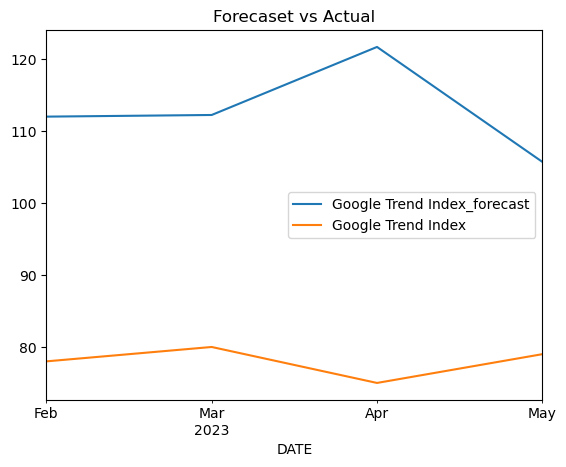

In [32]:
fig, axes = plt.subplots()

df_result['Google Trend Index_forecast'].plot(legend=True)
df_test['Google Trend Index'][-nobs:].plot(legend=True)
axes.set_title("Forecaset vs Actual")

;

### 12. Evaluate the model
- Root Mean Squared Error (RMSE)
- Mean Absolute Error(MAE)
- Mean Squiared Error (MSE)
- Mean Absolute Percentage Error (MAPE)

In [33]:
from statsmodels.tools.eval_measures import rmse, meanabs, mse
from sklearn.metrics import mean_absolute_percentage_error as mape
measures = [rmse, meanabs, mse, mape]

In [34]:
#Create a function to show the dataframe of the result for a given model
def eval_summary(model_name, df_result, df_test):
    fc_google_trend = df_result['Google Trend Index_forecast']
    actual_google_trend = df_test['Google Trend Index'][-nobs:]
    evaluations = {'RMSE':[], 'MAE':[],'MSE':[],'MAPE':[]}
    
    for m, e in zip(measures, evaluations):
        measure = m(fc_google_trend, actual_google_trend)
        evaluations[e].append(measure)
    
    evaluations.update({'Model_name':[]})
    evaluations['Model_name'] = model_name
    
    summary = pd.DataFrame.from_dict(evaluations)
    return summary

In [35]:
eval_summary('Model_1', df_result, df_test)

,RMSE,MAE,MSE,MAPE,Model_name
0,35.689,34.932,1273.714,0.307,Model_1


### 13. Find the best combination of input variables

In [36]:
#create possible combinations of input variables

from itertools import combinations
input_vars = list(df.columns.values)
input_vars.remove('Google Trend Index')

combos = []
for n in range(1, len(input_vars)+1):
    combos+=list(combinations(input_vars,n))
    
variables_combos = []
for i in combos:
    variables_combos.append(list(i))

print(variables_combos)
    
len(variables_combos)

[['Visitor Volume'], ['Average Daily Room Rate (ADR)'], ['CPI'], ['Unemployment Rate'], ['Visitor Volume', 'Average Daily Room Rate (ADR)'], ['Visitor Volume', 'CPI'], ['Visitor Volume', 'Unemployment Rate'], ['Average Daily Room Rate (ADR)', 'CPI'], ['Average Daily Room Rate (ADR)', 'Unemployment Rate'], ['CPI', 'Unemployment Rate'], ['Visitor Volume', 'Average Daily Room Rate (ADR)', 'CPI'], ['Visitor Volume', 'Average Daily Room Rate (ADR)', 'Unemployment Rate'], ['Visitor Volume', 'CPI', 'Unemployment Rate'], ['Average Daily Room Rate (ADR)', 'CPI', 'Unemployment Rate'], ['Visitor Volume', 'Average Daily Room Rate (ADR)', 'CPI', 'Unemployment Rate']]


15

#### Repeat the process from 8

In [37]:
list(range(1,len(variables_combos)+1))

model_names = []
for i in list(range(1,len(variables_combos)+1)):
    model_names.append("model_"+str(i))
    
model_names

['model_1',
 'model_2',
 'model_3',
 'model_4',
 'model_5',
 'model_6',
 'model_7',
 'model_8',
 'model_9',
 'model_10',
 'model_11',
 'model_12',
 'model_13',
 'model_14',
 'model_15']

In [38]:
tuples = [(key, value)
          for i, (key, value) in enumerate(zip(model_names, variables_combos))]
all_models = dict(tuples)
all_models

{'model_1': ['Visitor Volume'],
 'model_2': ['Average Daily Room Rate (ADR)'],
 'model_3': ['CPI'],
 'model_4': ['Unemployment Rate'],
 'model_5': ['Visitor Volume', 'Average Daily Room Rate (ADR)'],
 'model_6': ['Visitor Volume', 'CPI'],
 'model_7': ['Visitor Volume', 'Unemployment Rate'],
 'model_8': ['Average Daily Room Rate (ADR)', 'CPI'],
 'model_9': ['Average Daily Room Rate (ADR)', 'Unemployment Rate'],
 'model_10': ['CPI', 'Unemployment Rate'],
 'model_11': ['Visitor Volume', 'Average Daily Room Rate (ADR)', 'CPI'],
 'model_12': ['Visitor Volume',
  'Average Daily Room Rate (ADR)',
  'Unemployment Rate'],
 'model_13': ['Visitor Volume', 'CPI', 'Unemployment Rate'],
 'model_14': ['Average Daily Room Rate (ADR)', 'CPI', 'Unemployment Rate'],
 'model_15': ['Visitor Volume',
  'Average Daily Room Rate (ADR)',
  'CPI',
  'Unemployment Rate']}

In [39]:
#Function to find try all possible combos
def build_VAR(model_name,differenced_df=all_differenced):
    
    ## Create a subset of dataframe with a given input variable combination ##
    a = all_models.get(model_name)
    a.insert(0,'Google Trend Index')
    b = a.copy()
    print(b)
    subset_df = differenced_df[b]

    ## create a new VAR model with the selected variables ##
    model = VAR(subset_df)

    ## Find the optimal order (p) for a given VAR model ##
    x = model.select_order(maxlags = 7)
    print(x.summary())
    selected_p = x.selected_orders['aic']

    ## Train the model with the selected order(p) ##
    if selected_p >0:
        model_fitted = model.fit(selected_p)
    else: model_fitted = model.fit(None)
    print(model_fitted.summary())


    ## Check for serial correlation of residuals using Durbin Watson Statistics ##
    from statsmodels.stats.stattools import durbin_watson
    out = durbin_watson(model_fitted.resid)  #Residuals of response variable resulting from estimated coefficients
    
    print ("\n\n/// The Durbin Watson Test ///")
    for col, val in zip(subset_df.columns, out):
        print(col, ":", round(val,2))


    ## Forecast ##
    lag_order = model_fitted.k_ar

    #input data for forecasting
    forecast_input = subset_df.values[-lag_order:]

    fc = model_fitted.forecast(y=forecast_input, steps=nobs)
    df_forecast = pd.DataFrame(fc, index=df.index[-nobs:], columns = subset_df.columns + '_fc')
    df_forecast


    ## Inverse the differenced values ##
    df_result = de_defference('Google Trend Index', df_train,df_forecast)
    df_result

    ## Plot the result ##
    fig, axes = plt.subplots()
    df_result['Google Trend Index_forecast'].plot(legend=True)
    df_test['Google Trend Index'][-nobs:].plot(legend=True)
    axes.set_title(f"Forecaset vs Actual: {model_name}")
    axes.set_ylim(70, 106)

    ## Evaluate the model
    summary = eval_summary(model_name, df_result, df_test)
    return summary

['Google Trend Index', 'Visitor Volume']
 VAR Order Selection (* highlights the minimums) 
      AIC         BIC         FPE         HQIC   
-------------------------------------------------
0       2.261      2.336*       9.596      2.290*
1       2.270       2.495       9.685       2.357
2      2.238*       2.613      9.386*       2.382
3       2.283       2.808       9.837       2.484
4       2.398       3.073       11.07       2.657
5       2.356       3.182       10.69       2.673
6       2.438       3.414       11.70       2.812
7       2.469       3.594       12.21       2.900
-------------------------------------------------
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sat, 22, Jul, 2023
Time:                     12:04:57
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    2.49470
Nobs:                     57.0000    HQIC:    

/Users/wakanamorlan/anaconda3/envs/py310/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


,RMSE,MAE,MSE,MAPE,Model_name
0,3.821,3.263,14.597,0.044,model_1


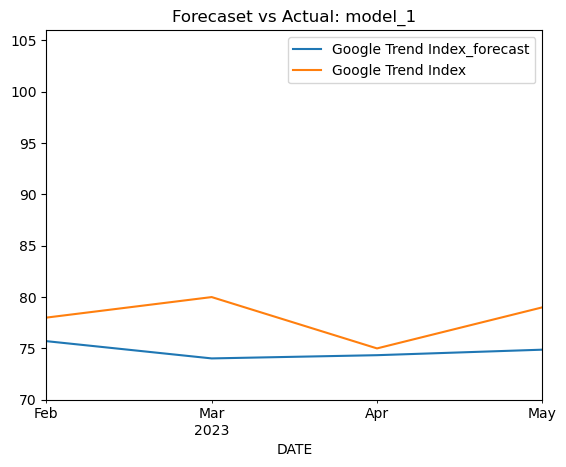

In [40]:
model_1 = build_VAR("model_1")
model_1

['Google Trend Index', 'Average Daily Room Rate (ADR)']
 VAR Order Selection (* highlights the minimums) 
      AIC         BIC         FPE         HQIC   
-------------------------------------------------
0       3.009      3.084*       20.27      3.038*
1       2.992       3.217       19.92       3.078
2      2.911*       3.286      18.40*       3.055
3       2.998       3.523       20.11       3.199
4       3.140       3.815       23.26       3.399
5       3.230       4.055       25.60       3.546
6       3.324       4.300       28.39       3.698
7       3.319       4.445       28.58       3.751
-------------------------------------------------
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sat, 22, Jul, 2023
Time:                     12:04:58
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    3.21692
Nobs:                     57.00

/Users/wakanamorlan/anaconda3/envs/py310/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


,RMSE,MAE,MSE,MAPE,Model_name
0,5.230,4.772,27.349,0.065,model_2


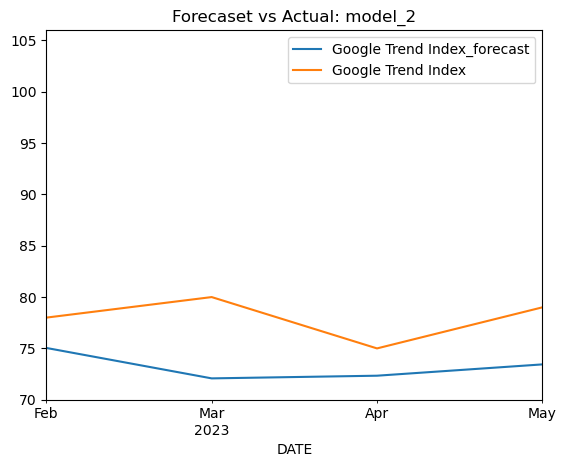

In [41]:
model_2= build_VAR('model_2')
model_2

['Google Trend Index', 'CPI']
 VAR Order Selection (* highlights the minimums) 
      AIC         BIC         FPE         HQIC   
-------------------------------------------------
0      -1.404     -1.329*      0.2456      -1.375
1      -1.344      -1.118      0.2610      -1.257
2     -1.608*      -1.233     0.2005*     -1.464*
3      -1.477     -0.9521      0.2290      -1.276
4      -1.604     -0.9286      0.2025      -1.345
5      -1.532     -0.7065      0.2189      -1.216
6      -1.604     -0.6289      0.2054      -1.230
7      -1.490     -0.3641      0.2331      -1.058
-------------------------------------------------
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sat, 22, Jul, 2023
Time:                     12:04:58
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -1.35193
Nobs:                     57.0000    HQIC:               

/Users/wakanamorlan/anaconda3/envs/py310/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


,RMSE,MAE,MSE,MAPE,Model_name
0,1.880,1.661,3.535,0.021,model_3


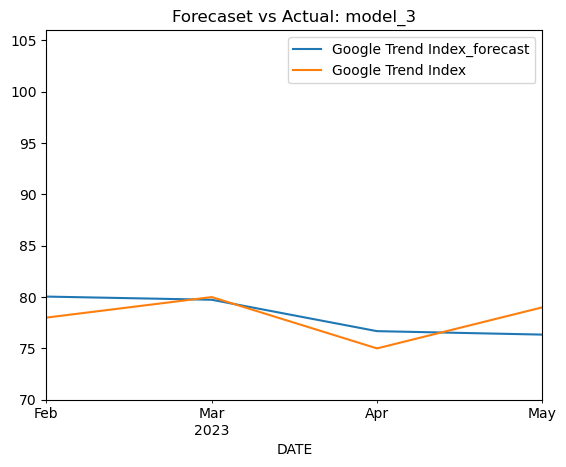

In [42]:
model_3 = build_VAR('model_3')
model_3

['Google Trend Index', 'Unemployment Rate']
 VAR Order Selection (* highlights the minimums) 
      AIC         BIC         FPE         HQIC   
-------------------------------------------------
0      4.708*      4.783*      110.9*      4.737*
1       4.796       5.021       121.1       4.882
2       4.779       5.154       119.2       4.923
3       4.890       5.415       133.3       5.091
4       4.938       5.614       140.5       5.197
5       4.999       5.824       150.2       5.315
6       5.054       6.030       160.1       5.428
7       4.966       6.091       148.3       5.397
-------------------------------------------------
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sat, 22, Jul, 2023
Time:                     12:04:58
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    4.87980
Nobs:                     58.0000    HQIC: 

/Users/wakanamorlan/anaconda3/envs/py310/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


,RMSE,MAE,MSE,MAPE,Model_name
0,1.894,1.586,3.586,0.020,model_4


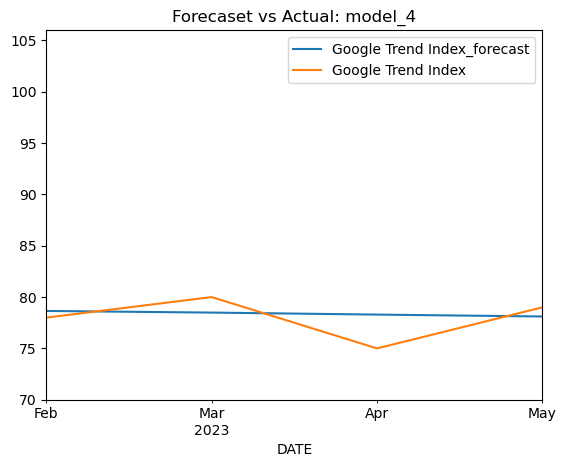

In [43]:
model_4 = build_VAR('model_4')
model_4

['Google Trend Index', 'Visitor Volume', 'Average Daily Room Rate (ADR)']
 VAR Order Selection (* highlights the minimums) 
      AIC         BIC         FPE         HQIC   
-------------------------------------------------
0      0.9124      1.025*       2.490      0.9555
1      0.7233       1.174       2.063     0.8959*
2     0.6295*       1.417      1.886*      0.9316
3      0.7363       1.862       2.119       1.168
4      0.9245       2.388       2.604       1.486
5       1.060       2.861       3.070       1.750
6       1.170       3.309       3.583       1.990
7       1.198       3.674       3.926       2.147
-------------------------------------------------
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sat, 22, Jul, 2023
Time:                     12:04:58
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                    1.22196
Nobs:        

/Users/wakanamorlan/anaconda3/envs/py310/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


,RMSE,MAE,MSE,MAPE,Model_name
0,7.623,7.229,58.103,0.103,model_5


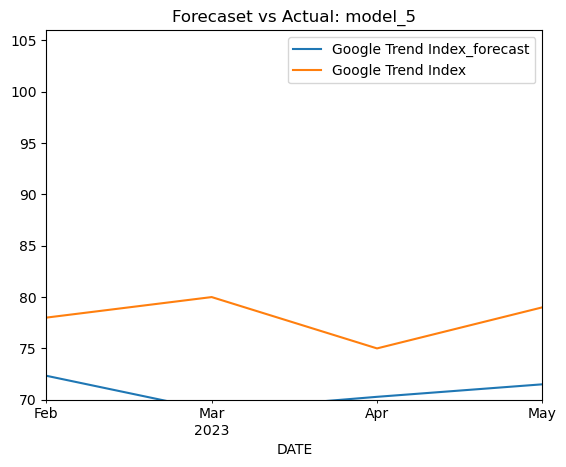

In [44]:
model_5 = build_VAR('model_5')
model_5

['Google Trend Index', 'Visitor Volume', 'CPI']
 VAR Order Selection (* highlights the minimums) 
      AIC         BIC         FPE         HQIC   
-------------------------------------------------
0      -3.356     -3.243*     0.03489     -3.312*
1      -3.303      -2.853     0.03681      -3.130
2      -3.457      -2.669     0.03167      -3.155
3      -3.286      -2.160     0.03794      -2.855
4      -3.594      -2.131    0.02839*      -3.033
5      -3.498      -1.696     0.03220      -2.807
6     -3.644*      -1.505     0.02909      -2.824
7      -3.400     -0.9231     0.03957      -2.450
-------------------------------------------------
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sat, 22, Jul, 2023
Time:                     12:04:58
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -1.57353
Nobs:                     53.0000    HQ

/Users/wakanamorlan/anaconda3/envs/py310/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


,RMSE,MAE,MSE,MAPE,Model_name
0,2.401,2.184,5.763,0.027,model_6


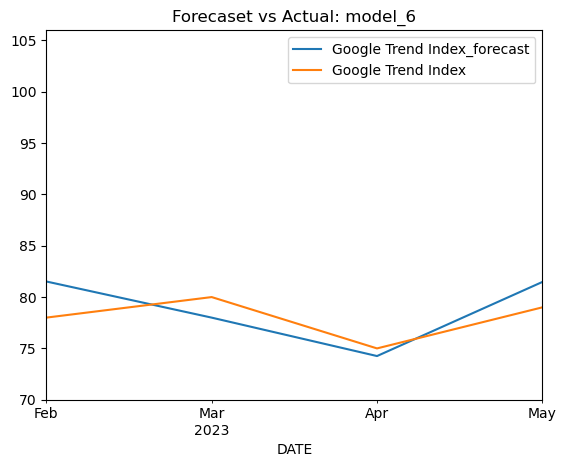

In [45]:
model_6 = build_VAR('model_6')
model_6

['Google Trend Index', 'Visitor Volume', 'Unemployment Rate']
 VAR Order Selection (* highlights the minimums) 
      AIC         BIC         FPE         HQIC   
-------------------------------------------------
0       2.649       2.762       14.15       2.693
1      2.232*      2.682*      9.323*      2.404*
2       2.337       3.125       10.40       2.639
3       2.447       3.572       11.72       2.878
4       2.653       4.117       14.67       3.214
5       2.505       4.306       13.03       3.196
6       2.595       4.733       14.89       3.415
7       2.381       4.857       12.82       3.330
-------------------------------------------------
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sat, 22, Jul, 2023
Time:                     12:04:58
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                    2.43245
Nobs:                    

/Users/wakanamorlan/anaconda3/envs/py310/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


,RMSE,MAE,MSE,MAPE,Model_name
0,1.874,1.479,3.510,0.019,model_7


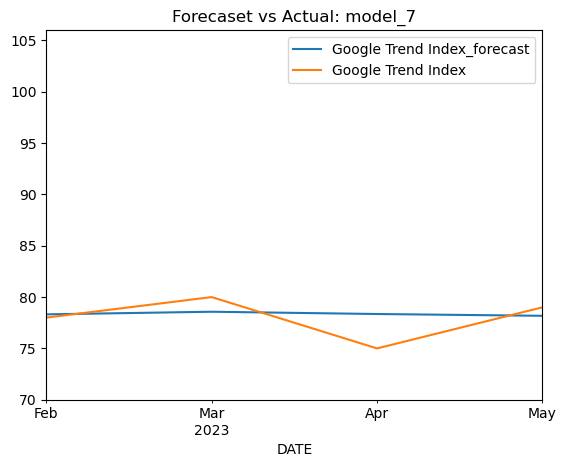

In [46]:
model_7 = build_VAR('model_7')
model_7

['Google Trend Index', 'Average Daily Room Rate (ADR)', 'CPI']
 VAR Order Selection (* highlights the minimums) 
      AIC         BIC         FPE         HQIC   
-------------------------------------------------
0      -2.629     -2.517*     0.07213      -2.586
1      -2.611      -2.161     0.07354      -2.438
2     -2.898*      -2.110    0.05541*     -2.596*
3      -2.737      -1.612     0.06569      -2.306
4      -2.618      -1.154     0.07538      -2.057
5      -2.445     -0.6436     0.09228      -1.754
6      -2.555     -0.4164     0.08638      -1.735
7      -2.415     0.06142      0.1059      -1.466
-------------------------------------------------
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sat, 22, Jul, 2023
Time:                     12:04:58
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -2.31834
Nobs:                   

/Users/wakanamorlan/anaconda3/envs/py310/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


,RMSE,MAE,MSE,MAPE,Model_name
0,2.161,1.945,4.671,0.025,model_8


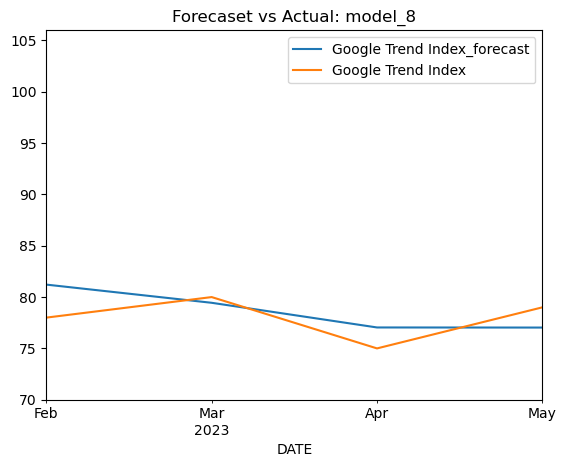

In [47]:
model_8 = build_VAR('model_8')
model_8

['Google Trend Index', 'Average Daily Room Rate (ADR)', 'Unemployment Rate']
 VAR Order Selection (* highlights the minimums) 
      AIC         BIC         FPE         HQIC   
-------------------------------------------------
0       3.264      3.376*       26.15      3.307*
1       3.339       3.790       28.23       3.512
2      3.202*       3.990      24.71*       3.504
3       3.330       4.456       28.35       3.762
4       3.568       5.032       36.63       4.129
5       3.799       5.600       47.50       4.489
6       3.948       6.086       57.61       4.768
7       3.773       6.249       51.56       4.722
-------------------------------------------------
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sat, 22, Jul, 2023
Time:                     12:04:58
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                    3.79063
Nobs:     

/Users/wakanamorlan/anaconda3/envs/py310/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


,RMSE,MAE,MSE,MAPE,Model_name
0,5.013,4.557,25.133,0.062,model_9


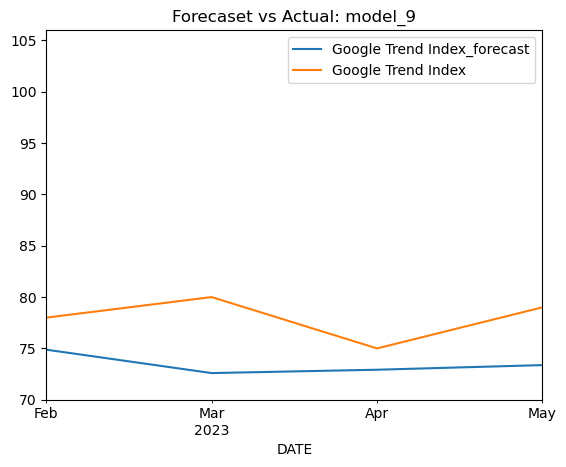

In [48]:
model_9 = build_VAR('model_9')
model_9

['Google Trend Index', 'CPI', 'Unemployment Rate']
 VAR Order Selection (* highlights the minimums) 
      AIC         BIC         FPE         HQIC   
-------------------------------------------------
0    -0.8922*    -0.7797*     0.4097*    -0.8491*
1     -0.7163     -0.2660      0.4890     -0.5436
2     -0.8194    -0.03140      0.4429     -0.5173
3     -0.6123      0.5134      0.5501     -0.1807
4     -0.7255      0.7380      0.5001     -0.1644
5     -0.5685       1.233      0.6025      0.1220
6     -0.6837       1.455      0.5613      0.1363
7     -0.7234       1.753      0.5751      0.2260
-------------------------------------------------
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sat, 22, Jul, 2023
Time:                     12:04:58
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                  -0.526247
Nobs:                     58.0000   

/Users/wakanamorlan/anaconda3/envs/py310/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


,RMSE,MAE,MSE,MAPE,Model_name
0,5.756,5.445,33.128,0.065,model_10


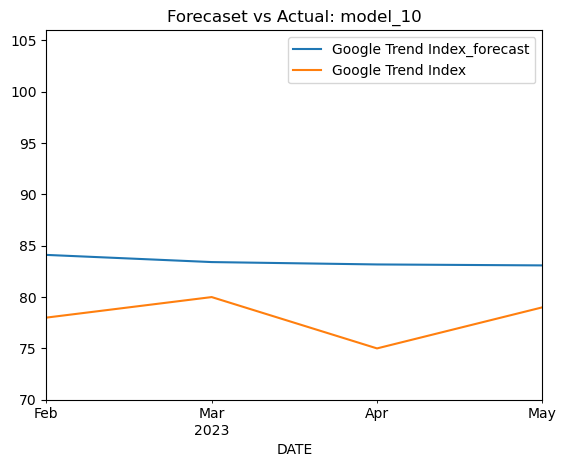

In [49]:
model_10 = build_VAR('model_10')
model_10

['Google Trend Index', 'Visitor Volume', 'Average Daily Room Rate (ADR)', 'CPI']
 VAR Order Selection (* highlights the minimums) 
      AIC         BIC         FPE         HQIC   
-------------------------------------------------
0      -4.730     -4.579*    0.008831      -4.672
1      -4.908      -4.157    0.007406      -4.620
2      -5.209      -3.858   0.005545*     -4.691*
3      -5.224      -3.273    0.005623      -4.476
4     -5.272*      -2.720    0.005674      -4.293
5      -5.023      -1.871    0.008000      -3.815
6      -4.980      -1.227    0.009715      -3.541
7      -4.639     -0.2867     0.01716      -2.971
-------------------------------------------------
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sat, 22, Jul, 2023
Time:                     12:04:59
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                   -2.92986
Nobs: 

/Users/wakanamorlan/anaconda3/envs/py310/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


,RMSE,MAE,MSE,MAPE,Model_name
0,2.496,1.891,6.229,0.024,model_11


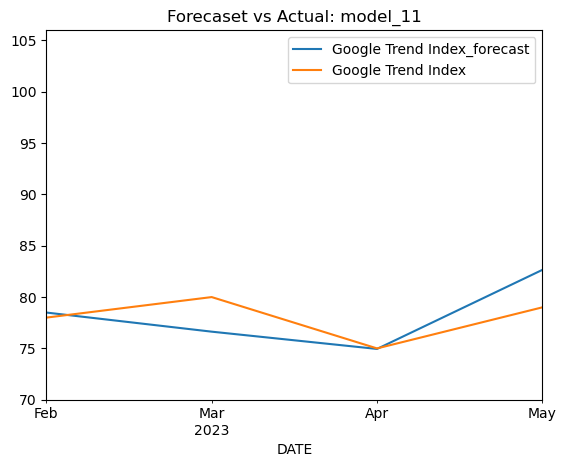

In [50]:
model_11 = build_VAR('model_11')
model_11

['Google Trend Index', 'Visitor Volume', 'Average Daily Room Rate (ADR)', 'Unemployment Rate']
 VAR Order Selection (* highlights the minimums) 
      AIC         BIC         FPE         HQIC   
-------------------------------------------------
0       1.129       1.279       3.092       1.186
1      0.4569      1.207*       1.583     0.7446*
2      0.4451       1.796      1.583*      0.9630
3      0.6300       2.581       1.961       1.378
4      0.7747       3.326       2.397       1.753
5      0.7110       3.863       2.475       1.919
6      0.6830       4.435       2.797       2.122
7     0.1346*       4.487       2.032       1.803
-------------------------------------------------
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sat, 22, Jul, 2023
Time:                     12:04:59
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                    

/Users/wakanamorlan/anaconda3/envs/py310/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


,RMSE,MAE,MSE,MAPE,Model_name
0,9.633,8.704,92.797,0.111,model_12


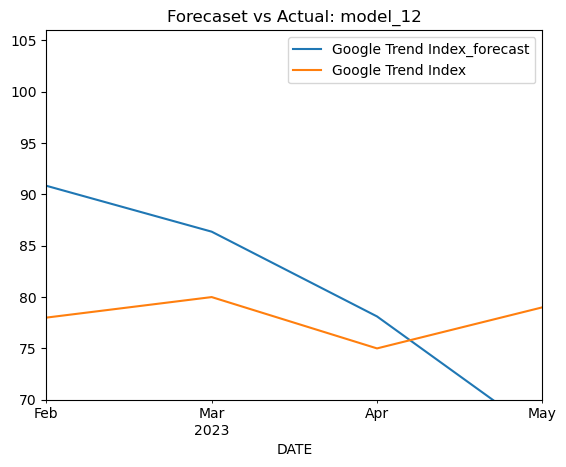

In [51]:
model_12 = build_VAR('model_12')
model_12

['Google Trend Index', 'Visitor Volume', 'CPI', 'Unemployment Rate']
 VAR Order Selection (* highlights the minimums) 
      AIC         BIC         FPE         HQIC   
-------------------------------------------------
0      -2.968     -2.818*     0.05140      -2.911
1      -3.290      -2.539    0.03735*     -3.002*
2      -3.287      -1.937     0.03788      -2.770
3      -3.120      -1.169     0.04611      -2.372
4      -3.236     -0.6845     0.04344      -2.258
5      -3.428     -0.2763     0.03943      -2.220
6      -3.511      0.2419     0.04222      -2.072
7     -3.554*      0.7984     0.05079      -1.886
-------------------------------------------------
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sat, 22, Jul, 2023
Time:                     12:04:59
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                   0.798364
Nobs:             

/Users/wakanamorlan/anaconda3/envs/py310/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


,RMSE,MAE,MSE,MAPE,Model_name
0,7.624,6.003,58.132,0.074,model_13


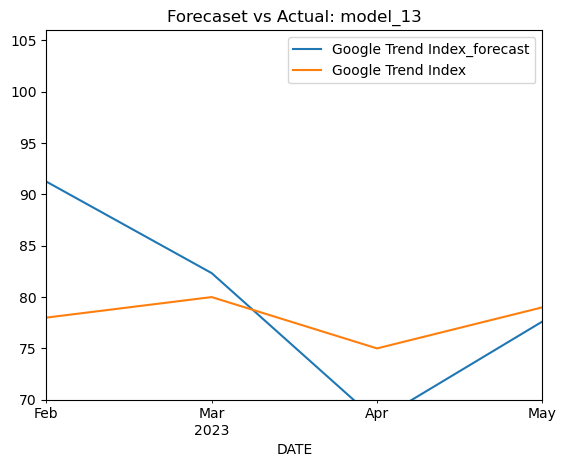

In [52]:
model_13 = build_VAR('model_13')
model_13

['Google Trend Index', 'Average Daily Room Rate (ADR)', 'CPI', 'Unemployment Rate']
 VAR Order Selection (* highlights the minimums) 
      AIC         BIC         FPE         HQIC   
-------------------------------------------------
0      -2.382     -2.232*     0.09237     -2.324*
1      -2.268      -1.518      0.1038      -1.980
2     -2.536*      -1.185    0.08028*      -2.018
3      -2.317     -0.3658      0.1029      -1.569
4      -2.026      0.5257      0.1457      -1.048
5      -1.696       1.456      0.2230     -0.4871
6      -1.716       2.037      0.2541     -0.2771
7      -1.835       2.518      0.2836     -0.1658
-------------------------------------------------
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sat, 22, Jul, 2023
Time:                     12:04:59
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                   -1.53568
Nob

/Users/wakanamorlan/anaconda3/envs/py310/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


,RMSE,MAE,MSE,MAPE,Model_name
0,2.404,2.092,5.779,0.026,model_14


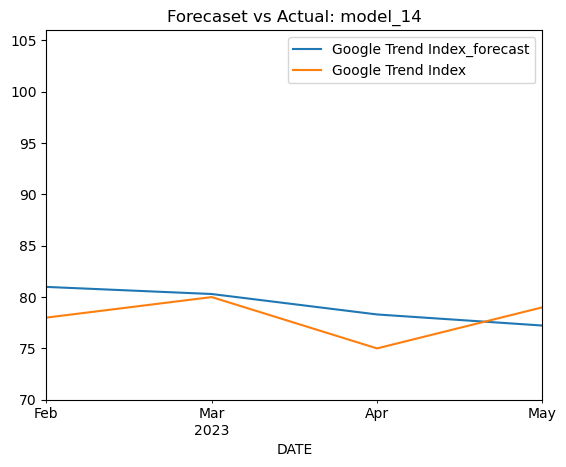

In [53]:
model_14 = build_VAR('model_14')
model_14

['Google Trend Index', 'Visitor Volume', 'Average Daily Room Rate (ADR)', 'CPI', 'Unemployment Rate']
 VAR Order Selection (* highlights the minimums) 
      AIC         BIC         FPE         HQIC   
-------------------------------------------------
0      -4.523     -4.335*     0.01086      -4.451
1      -5.166      -4.040    0.005737     -4.734*
2      -5.337      -3.273   0.004969*      -4.546
3      -5.296      -2.294    0.005555      -4.145
4      -5.324      -1.384    0.006221      -3.813
5      -5.596     -0.7179    0.006079      -3.726
6      -5.684      0.1321    0.008446      -3.454
7     -5.901*      0.8536     0.01357      -3.311
-------------------------------------------------
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sat, 22, Jul, 2023
Time:                     12:04:59
--------------------------------------------------------------------
No. of Equations:         5.00000    BIC:             

/Users/wakanamorlan/anaconda3/envs/py310/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


,RMSE,MAE,MSE,MAPE,Model_name
0,17.495,15.733,306.089,0.168,model_15


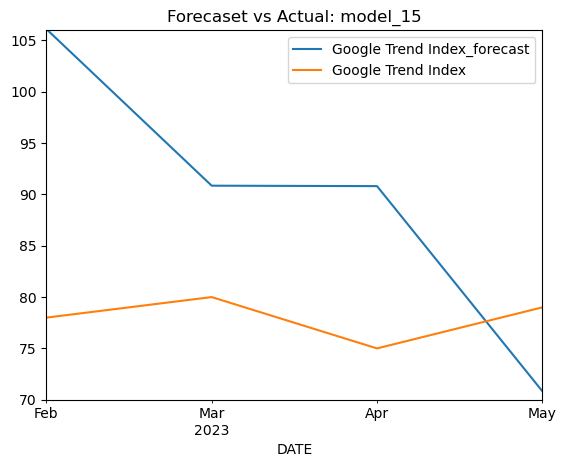

In [54]:
model_15 = build_VAR('model_15')
model_15

In [55]:
all_results = pd.concat([model_1, model_2, model_3, model_4, model_5, model_6, model_7, model_8, model_9, model_10, model_11,
         model_12, model_13, model_14, model_15])

all_results = all_results.set_index('Model_name')
all_results.sort_values('RMSE')

,RMSE,MAE,MSE,MAPE
Model_name,,,,
model_7,1.874,1.479,3.510,0.019
model_3,1.880,1.661,3.535,0.021
model_4,1.894,1.586,3.586,0.020
model_8,2.161,1.945,4.671,0.025
model_6,2.401,2.184,5.763,0.027
model_14,2.404,2.092,5.779,0.026
model_11,2.496,1.891,6.229,0.024
model_1,3.821,3.263,14.597,0.044
model_9,5.013,4.557,25.133,0.062
